In [1]:
import numpy as np
import os
import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt

import sys
from pathlib import Path
from scipy.signal import butter, lfilter

import json
import commentjson
import pickle
import scipy.io as sio
from pathlib import Path
import numpy as np

In [2]:
def parse_txt(text_lines):
    time, ch1, ch2 = [], [], []
    for i, line in enumerate(text_lines):
        if i < 6:
            continue
        line = line.split("; ")
        try:
            time.append(float(line[0]))
            ch1.append(float(line[1]))
            ch2.append(float(line[2]))
        except:
            print("End line at {} ".format(i))
            break
    return np.asarray(time), np.asarray(ch1), np.asarray(ch2)

def load_text(path):
    with open(path) as f:
        return [l.replace("\n", "") for l in f.readlines()]

In [3]:
#generate data
data_path = "../data/meas_scope_20210823.txt"
time, raw_data, triangle_waves = parse_txt(load_text(data_path))
root_dir = os.path.split(data_path)[0]

In [4]:
def cyc_searching (data,window):
    temp_max =0 ;
    i=0
    ind_min= 0;
    ind_max=0;
    A = data[0:window];
    B = data[window+1:2*window+1];
    if((np.max(B)-np.max(A))>0):
        direct ="up";
    else:
        direct = "down"
    collect = []
    while(1):
        A = data[i:i+window];
        B = data[i+window+1:i+2*window+1];
        if ((np.max(B)-np.max(A)) == 0): i=i+window;
        if(direct == "up"):
            #start collect
            if((np.max(B)-np.max(A))>0):       
                i=i+window;
                if((i+2*window+1)>len(data)): return collect;
            else:            
                ind_max=i+np.argmax(A)
                direct = "down";
                
        if(direct == "down"):        
            if((np.min(A)- np.min(B))>0):
                i=i+window;
                if((i+2*window+1)>len(data)): return  collect;
            else:
                ind_min=i+np.argmin(A)
                collect.append([ind_max,ind_min])
                direct = "up"

# Create pzt_index

In [5]:
window = 5000
ind = cyc_searching(triangle_waves,window)
ind

[[119496, 260101],
 [400687, 541377],
 [681949, 822650],
 [963225, 1103915],
 [1244472, 1385157],
 [1525730, 1666394],
 [1807048, 1947530],
 [2088290, 2228894],
 [2369490, 2510139],
 [2650736, 2791416],
 [2931963, 3072603],
 [3213291, 3353969],
 [3494489, 3635113],
 [3775834, 3916298],
 [4056907, 4197578],
 [4338238, 4478929],
 [4619632, 4760190],
 [4900720, 5041305],
 [5182099, 5322578],
 [5463230, 5603928],
 [5744624, 5885145],
 [6025744, 6166381],
 [6307023, 6447645],
 [6588315, 6728892],
 [6869451, 7010011],
 [7150637, 7291425],
 [7431953, 7572668],
 [7713228, 7853861],
 [7994484, 8135145]]

# Load 柏安Data

In [6]:
signal_det_path = "../data/det_idxs.npy"
signal_det= np.load(signal_det_path )

# Simulator & test

In [7]:
# trim the package due to evey package has different length to plot
def do_trim_package(ds):
    min_l=0xffffffff
    for num in range(len(ds)):
        l = len(ds[num][1])
        if(min_l>l): 
            min_l = l  
    if(min_l==0xffffffff):
        print("trim_error")     
    else:
        print("modified size = ", min_l)
        for num in range(len(ds)):           
            ds[num][1] = ds[num][1][0:min_l]
            ds[num][2] = ds[num][2][0:min_l]
    return ds
    
# rearrange all data and det_sig with 0 - lens
# for seeing every scanning as a single experiment
# the det_sig marked as 1 ; elsewhere as 0; 
def package_generator(pzt_ind, raw_data, det_peaks):
    ds = []
    for num in range(len(pzt_ind)):

        tmp_data=[]        
        first_ind = pzt_ind[num][0]
        final_ind = pzt_ind[num][1]
        tmp_data = raw_data[pzt_ind[num][0]:pzt_ind[num][1]]
        
        tmp_peaks=np.zeros(len(tmp_data))
        for peak in det_peaks:
            if ((peak>first_ind) & (peak < final_ind)):
                tmp_peaks[peak-first_ind] = 1 #marked
        ds.append([num, tmp_data, tmp_peaks])
    return ds


In [8]:
ds = package_generator(ind,raw_data,signal_det)
ds = do_trim_package(ds)

modified size =  140464


C:\Users\super\AppData\Local\Temp\ipykernel_7640\2313844907.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure()


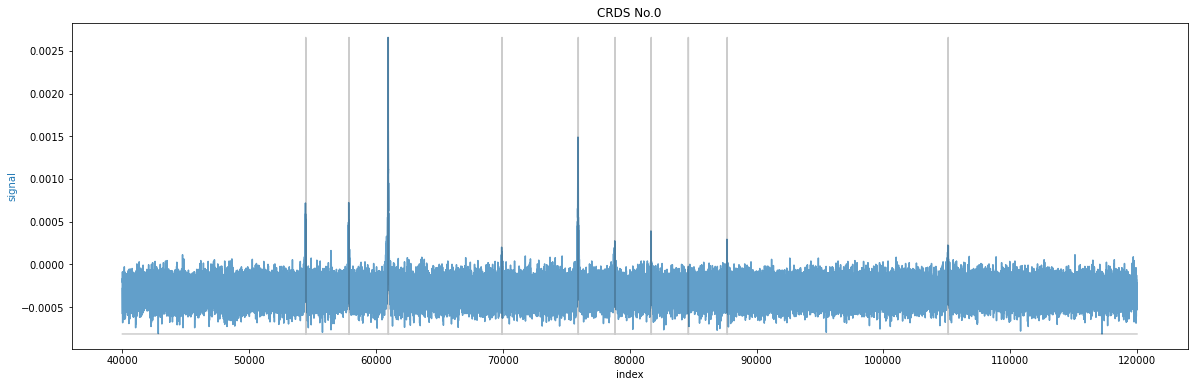

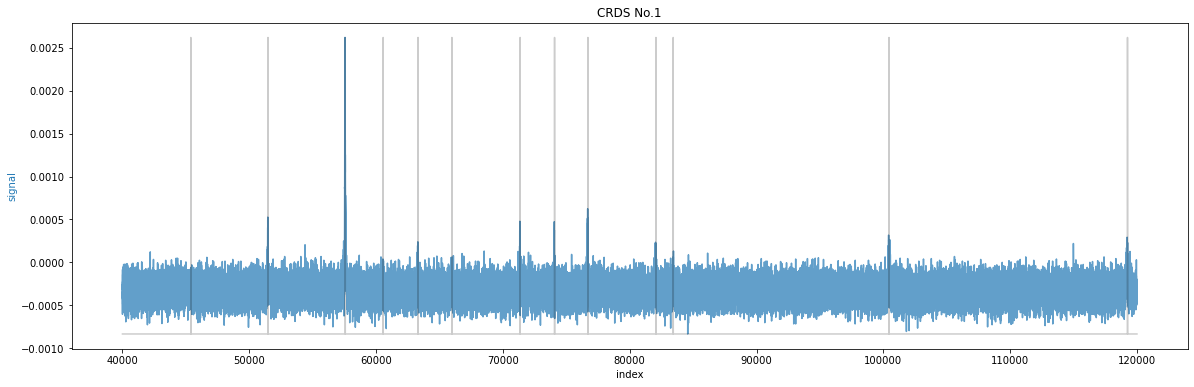

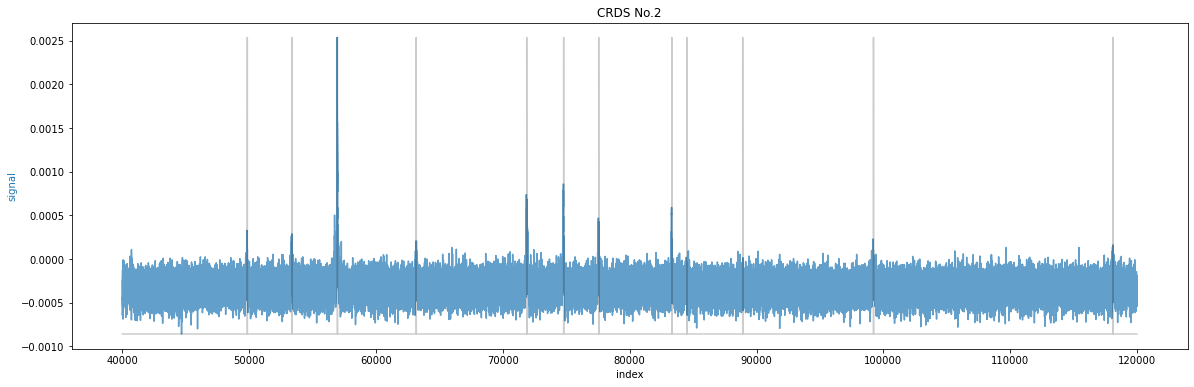

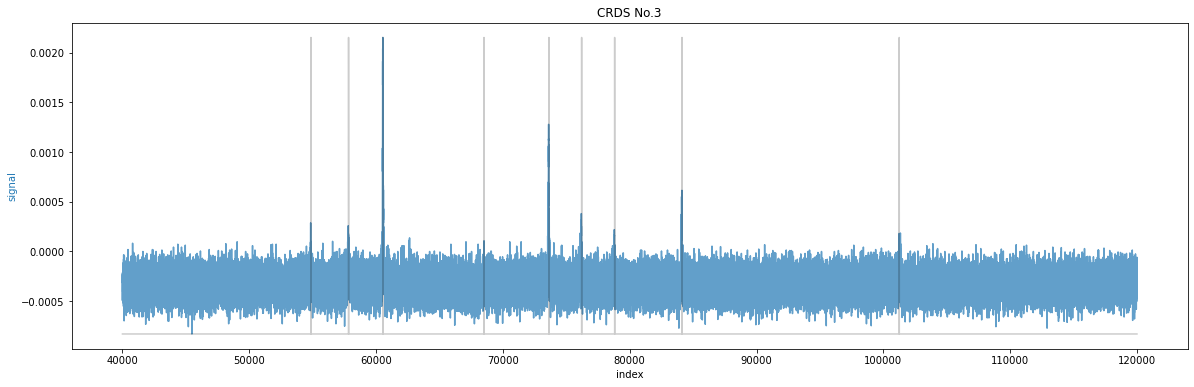

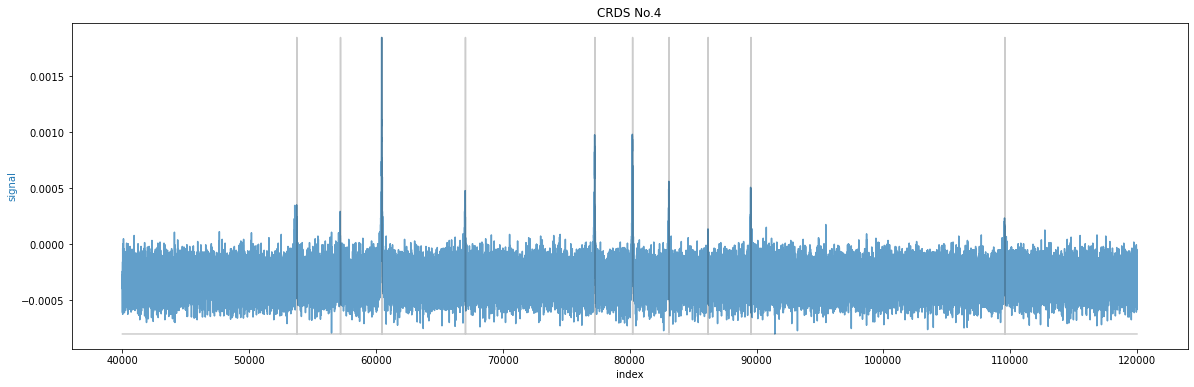

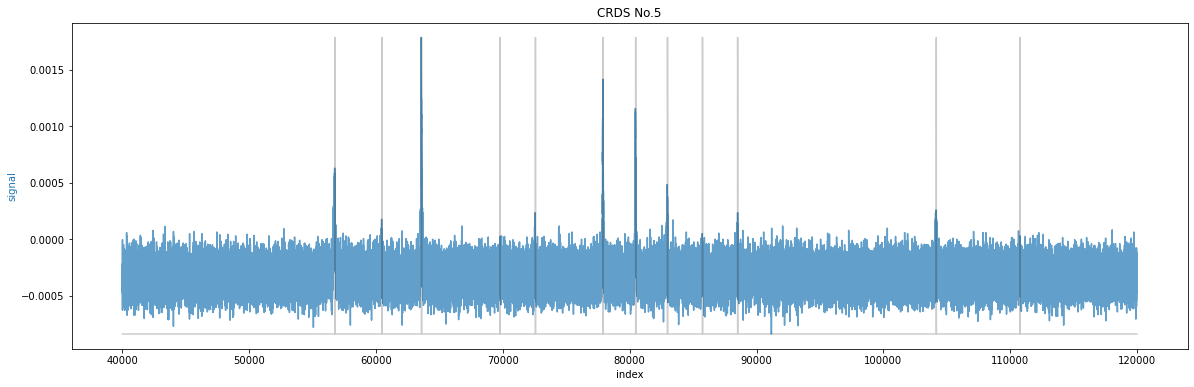

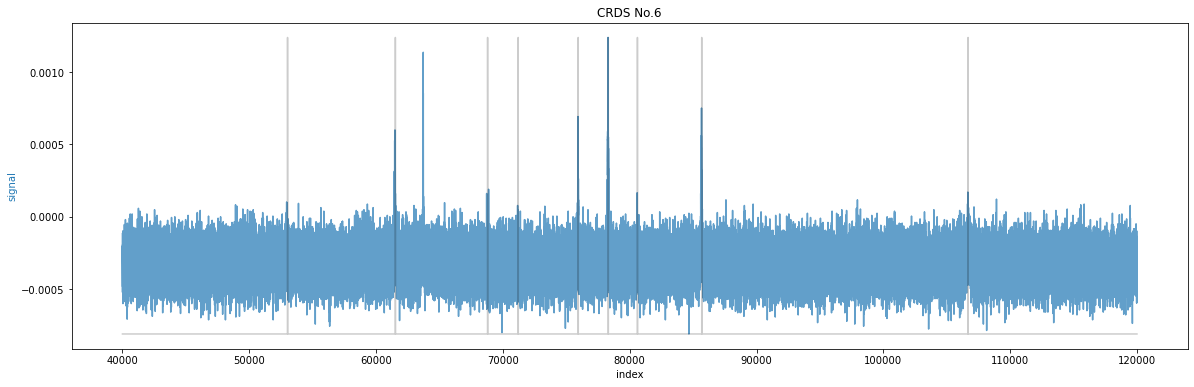

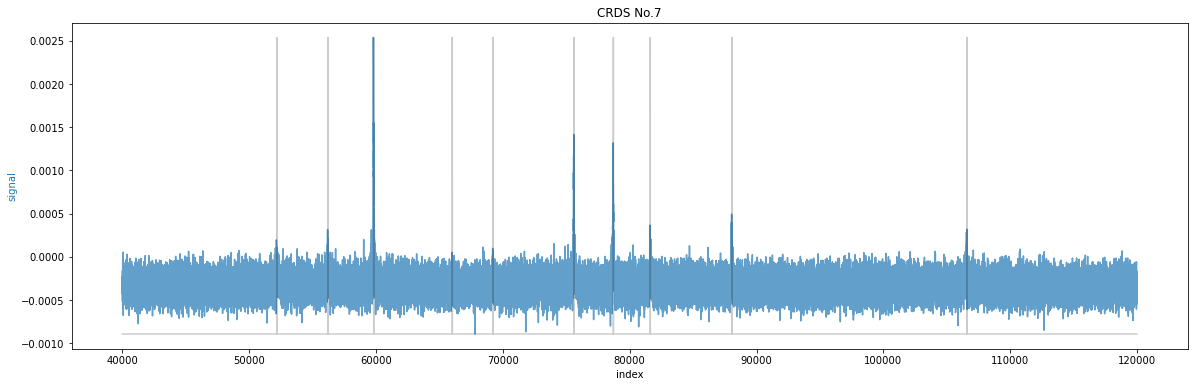

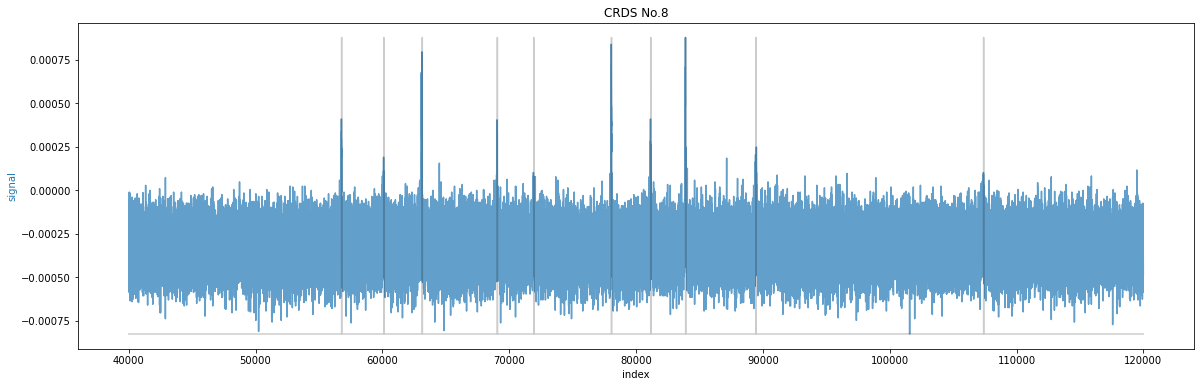

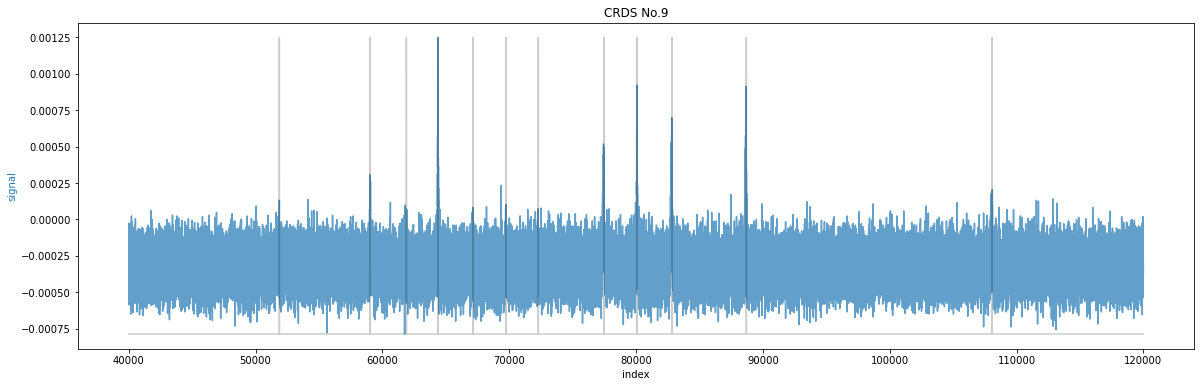

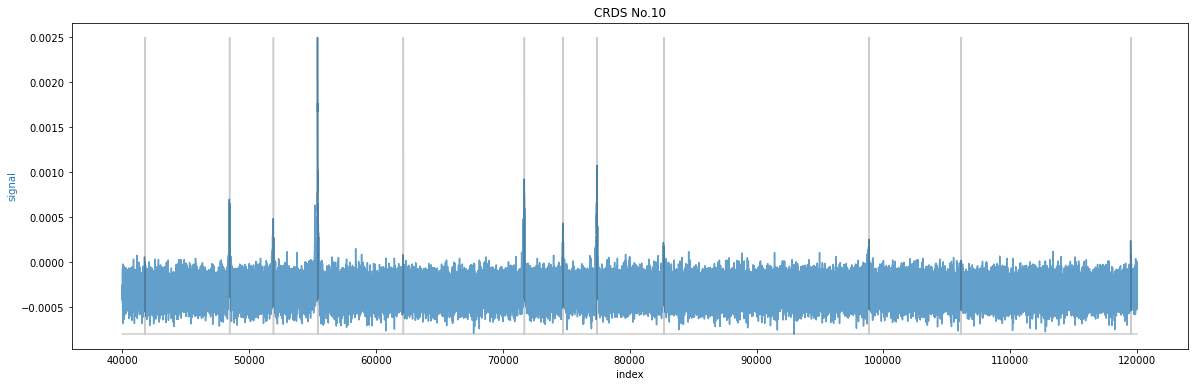

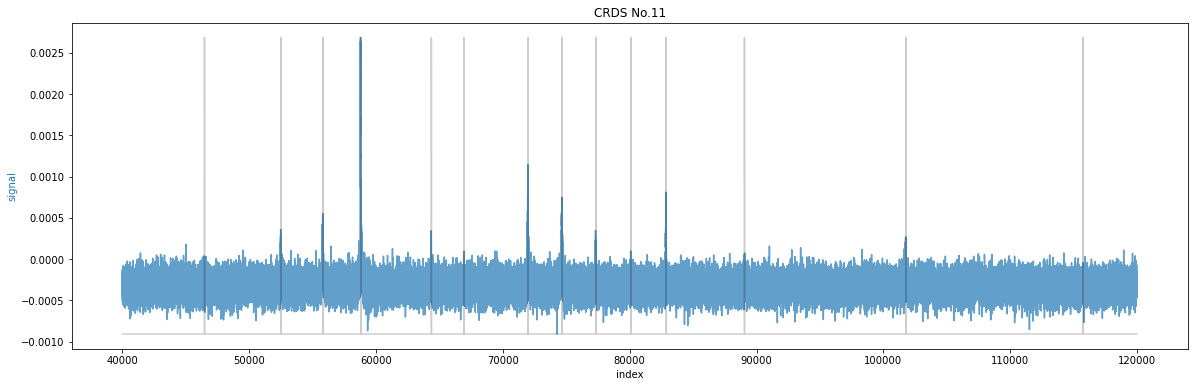

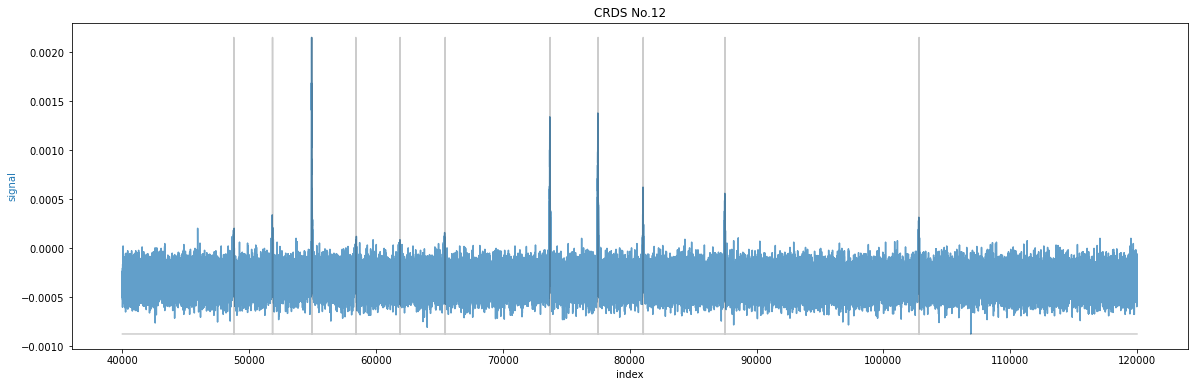

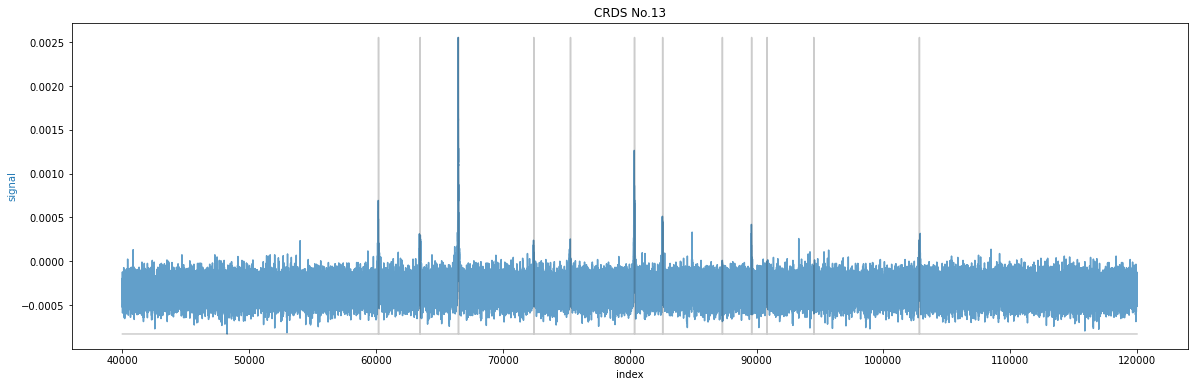

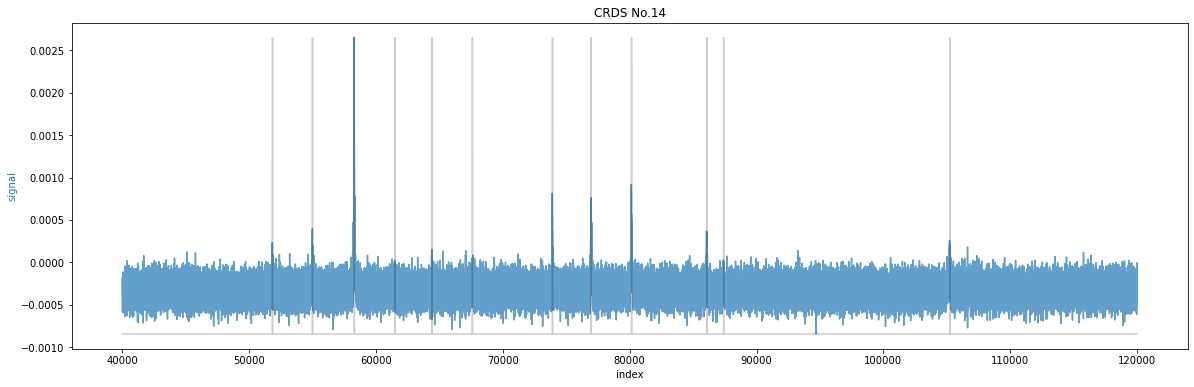

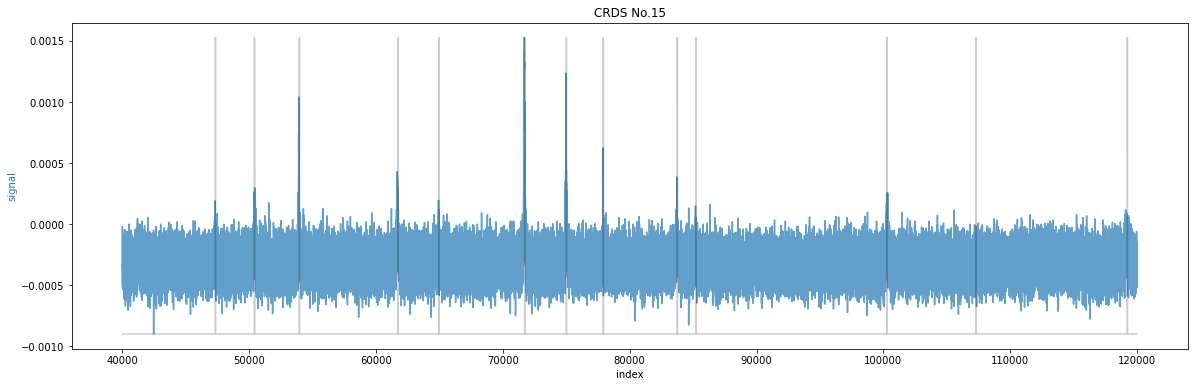

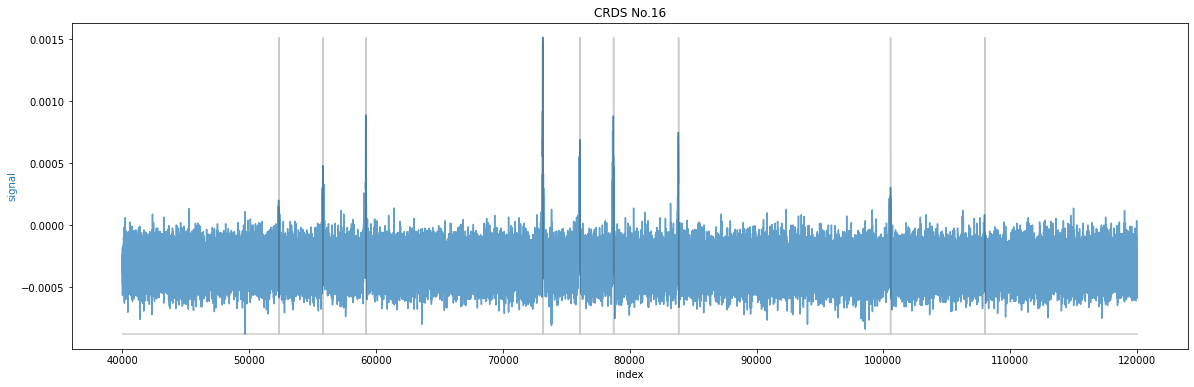

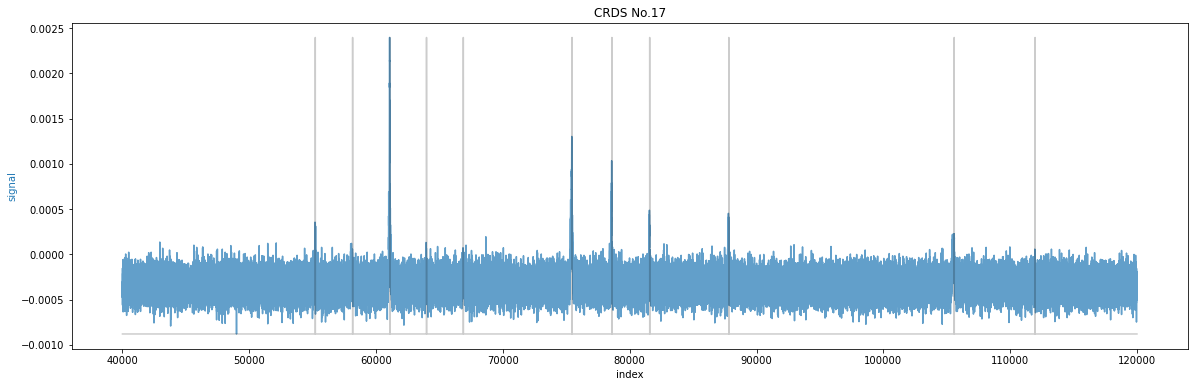

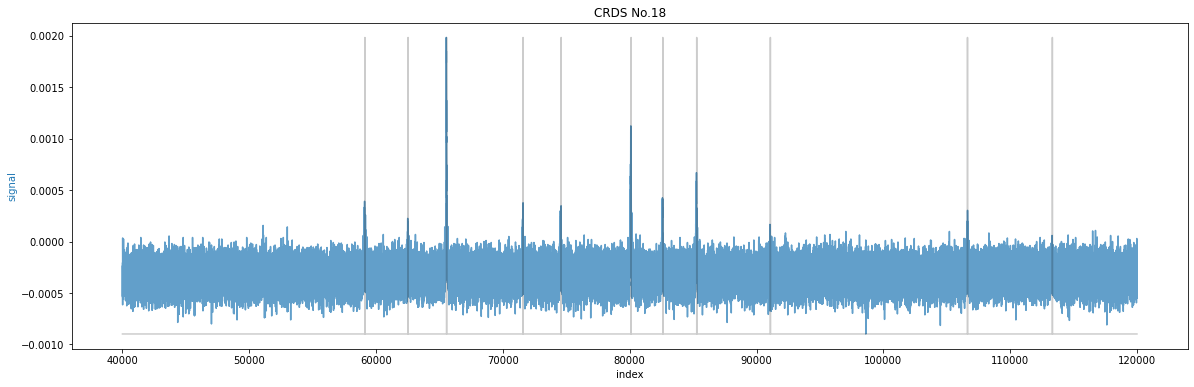

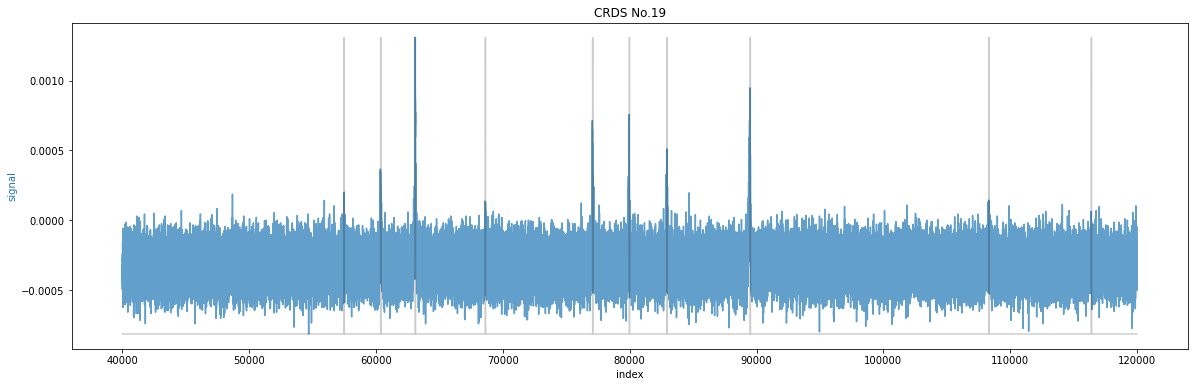

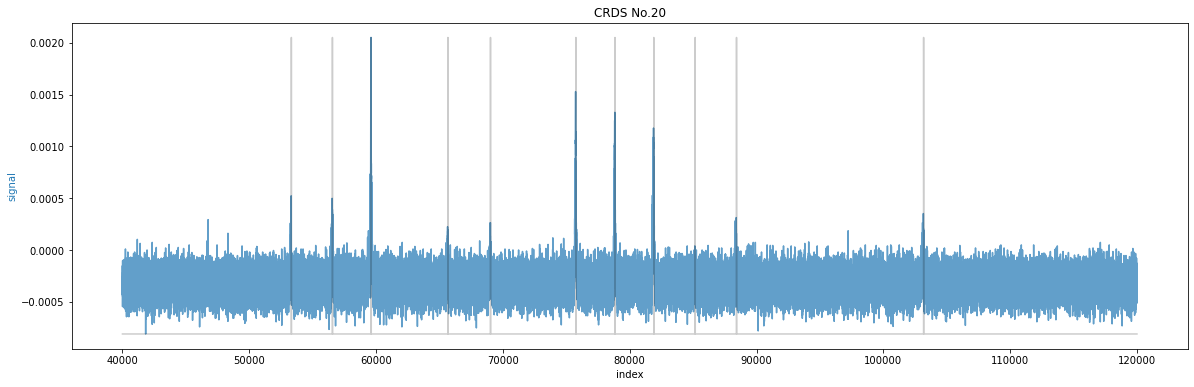

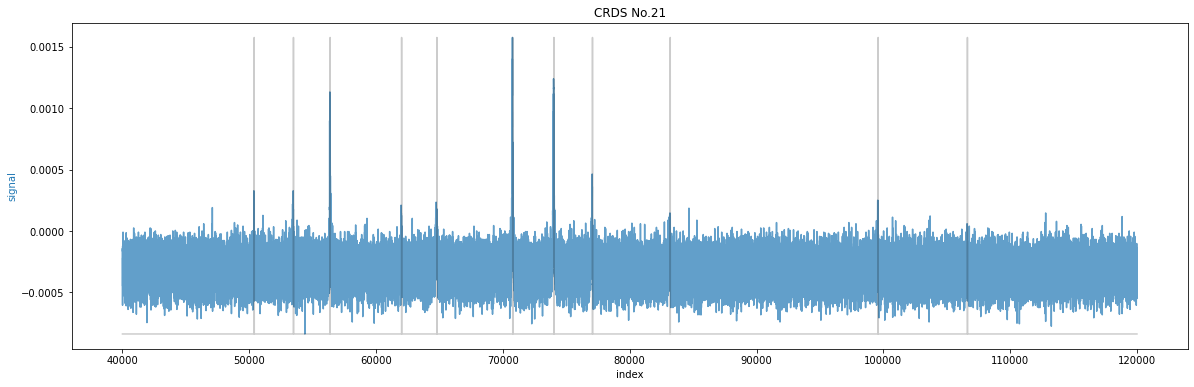

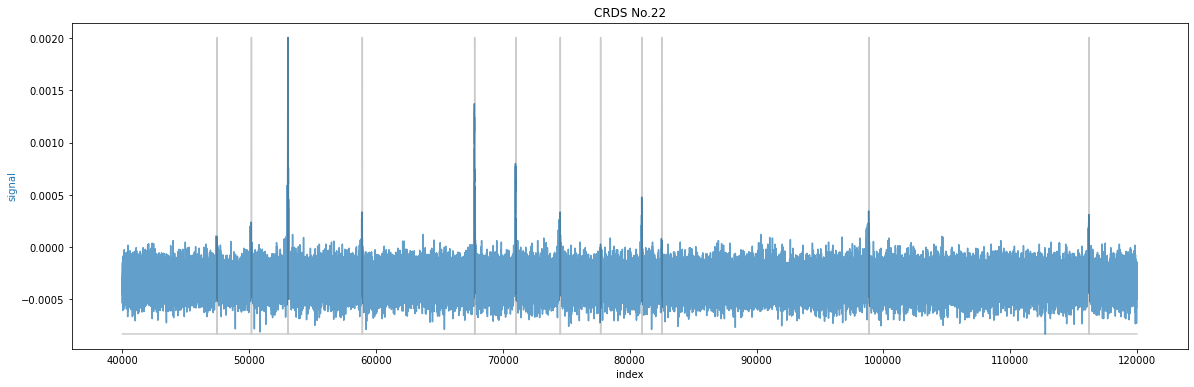

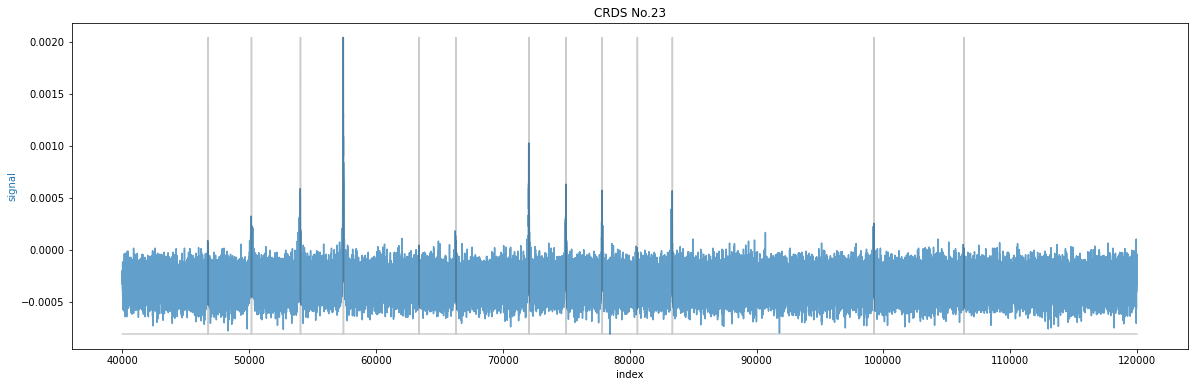

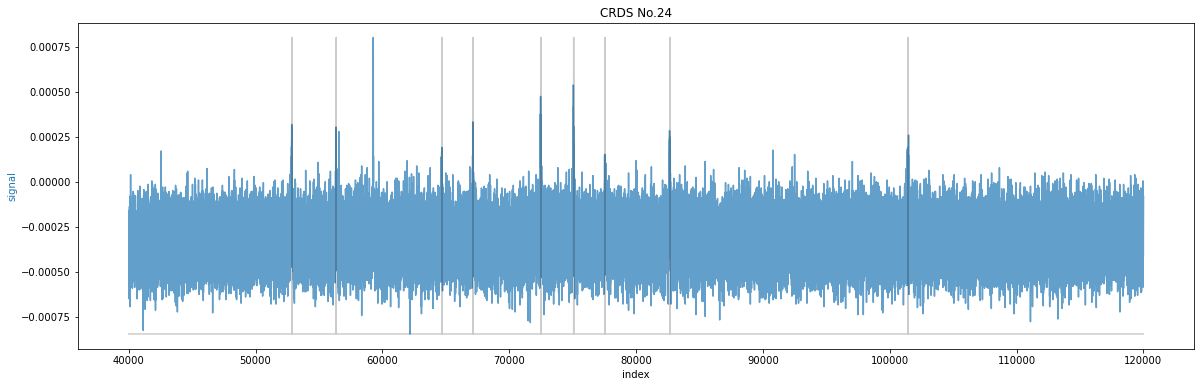

In [9]:

n=25
data_len = len(ds[1][1])
start = 40000
stop = 120000

x= np.arange(0, data_len,1)
x= x[start:stop]


for num in range(n): 
    y1 = ds[num][1][start:stop]
    max_val = max(y1)
    min_val = min(y1)
    mag = (max_val-min_val)
    y2 = ds[num][2][start:stop]* mag +  min_val

    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(6)
    plt.title('CRDS No.'+str(num))
    plt.xlabel('index')

    plt.ylabel('signal', color='tab:blue')

    plt.plot(x,y1, color='tab:blue', alpha=0.7) 
    plt.plot(x, y2, color='black', alpha=0.2)
    plt.savefig("./result/Fig."+str(num)+".jpg")